In [1]:
import cv2
import urllib.request 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import albumentations as alb 
import json
import os

Rename file


In [ ]:
count = 198
for file in os.listdir(os.path.join('Data_Raw', 'Long')) :
  # print(file)
  
  file_name = os.path.join('Data_Raw', 'Long', file)
  
  new_file = file.split('roi')[0] + f'roi{count}.jpg'
  
  dest = os.path.join('Data_Raw', 'Long', new_file)
  
  os.rename(file_name, dest)
  count += 1

Apply Image Augmentation on Images and Labels using Albumentations


In [3]:
# Setup Albumentations Transform 
augmentor = alb.Compose([
  alb.RandomCrop(width=450, height=450),
  alb.HorizontalFlip(p=0.5),
  alb.VerticalFlip(p=0.5),
  alb.RandomBrightnessContrast(p=0.2),
  alb.RandomGamma(p=0.2),
  alb.RGBShift(p=0.2),],
  bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels'])
)

In [21]:
image = cv2.imread(os.path.join('Data_Train', 'Long', 'z51985795_roi4.jpg'))
# image

In [5]:
# get coordinate from label file
with open(os.path.join('Data_Train', 'Long_Label', 'z51985795_roi4.json'), 'rb') as file :
  label = json.load(file)
print({
  "points" : label["shapes"][0]['points'],
  "fileName" : label["imagePath"].split('\\')[2]
})  
# coordinate = [0,0,0,0]
# coordinate[0] = label['shapes'][0]['points'][0][0]
# coordinate[1] = label['shapes'][0]['points'][0][1]
# coordinate[2] = label['shapes'][0]['points'][1][0]
# coordinate[3] = label['shapes'][0]['points'][1][1]

# Normalization
# coordinate = list(np.divide(coordinate, [640,480,640,480]))
# print(coordinate)

{'points': [[262.55952380952385, 176.9047619047619], [406.6071428571429, 376.30952380952385]], 'fileName': 'z51985795_roi4.jpg'}


In [24]:
# Apply augmentation and view results
augmented = augmentor(image=image, bboxes=[coordinate], class_labels=['Long'])
# print(augmented['image'])
print(augmented['class_labels'][0])
# print(augmented['points'])

Long


Build and Run Augmentation Pipeline


In [5]:
# Run Augmentation Pipeline
for folder in ['Data_Train', 'Data_Test', 'Data_Validation'] :
  for image_file in os.listdir(os.path.join(folder, 'Quoc')) :
    image = cv2.imread(os.path.join(folder, 'Quoc', image_file))
    
    coords = [0,0,0.0001,0.00001]
    label_path = os.path.join(folder, 'Quoc_Label', f'{image_file.split(".")[0]}.json')
    # print(label_path)
    if os.path.exists(label_path) :
      with open (label_path, 'rb') as file :
        label = json.load(file)
        # print(label)
      coords[0] = label['shapes'][0]['points'][0][0]
      coords[1] = label['shapes'][0]['points'][0][1]
      coords[2] = label['shapes'][0]['points'][1][0]
      coords[3] = label['shapes'][0]['points'][1][1]
      
      coords = list(np.divide(coords, [640,480,640,480]))
      
    try:
      for x in range(10) :
        # print(x)
        augmented = augmentor(image=image, bboxes=[coords], class_labels=['Quoc'])
        cv2.imwrite(os.path.join('Data_Augmented', folder, 'Quoc', f'{image_file.split(".")[0]}.{x}.jpg'), augmented['image'])

        annotation = {
          'image_file': '',
          'bbox': '',
          'class': '',
          'label': ''
        }
        annotation['image_file'] = image_file
        
        if os.path.exists(label_path) :
          if len(augmented['bboxes']) == 0 :
            annotation['bbox'] = [0,0,0,0]
            annotation['class'] = 0
          else :
            annotation['bbox'] = augmented['bboxes'][0]
            annotation['class'] = 1
            annotation['label'] = augmented['class_labels'][0]
        else :
          annotation['bbox'] = [0,0,0,0]
          annotation['class'] = 0
          
        with open(os.path.join('Data_Augmented', folder, 'quoc_label', f'{image_file.split(".")[0]}.{x}.json'), 'w') as f :
          json.dump(annotation, f)
    except Exception as e :
      print(e)

Load Augmented Images to Tensorflow Dataset


In [3]:
def load_image(file_path)  :
    byte_image = tf.io.read_file(file_path)
    image = tf.io.decode_jpeg(byte_image)
    return image


def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                images.append(img)
    return images

In [51]:
class_name = "long"

In [52]:
train_images = tf.data.Dataset.list_files(
    f"datasets/dataset-detection/train/{class_name}/*.jpg", shuffle=False
)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x : tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x : x/255) 

len(train_images)

2910

In [53]:
test_images = tf.data.Dataset.list_files(
    f"datasets/dataset-detection/test/{class_name}/*.jpg", shuffle=False
)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x : tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x : x/255)
# test_images.as_numpy_iterator().next()
len(test_images)

340

In [54]:
val_images = tf.data.Dataset.list_files(
    f"datasets/dataset-detection/val/{class_name}/*.jpg", shuffle=False
)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x : tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x : x/255)
# val_images.as_numpy_iterator().next()
len(val_images)

370

Prepare Labels


In [55]:
def load_label(label_path) :
  with open(label_path.numpy(), 'rb') as file :
    label = json.load(file)
  return [label['class']], label['bbox'], label['label']

In [56]:
train_labels = tf.data.Dataset.list_files(
    f'datasets/dataset-detection/train/{class_name}_label/*.json', shuffle=False
)
train_labels = train_labels.map(lambda x : tf.py_function(load_label, [x], [tf.uint8, tf.float16, tf.string]))
# train_labels.as_numpy_iterator().next()
len(train_labels)

2910

In [57]:
test_labels = tf.data.Dataset.list_files(
    f"datasets/dataset-detection/test/{class_name}_label/*.json", shuffle=False
)
test_labels = test_labels.map(lambda x : tf.py_function(load_label, [x], [tf.uint8, tf.float16, tf.string]))
# test_labels.as_numpy_iterator().next()[2].decode()
len(test_labels)

340

In [58]:
val_labels = tf.data.Dataset.list_files(
    f"datasets/dataset-detection/val/{class_name}_label/*.json", shuffle=False
)
val_labels = val_labels.map(lambda x : tf.py_function(load_label, [x], [tf.uint8, tf.float16, tf.string]))
# val_labels.as_numpy_iterator().next()
len(val_labels)

370

Combine Label and Image Samples


In [59]:
#  Check length of partitions
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels) 

(2910, 2910, 340, 340, 370, 370)

In [60]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)
# train.as_numpy_iterator().next()
# train.as_numpy_iterator().next()[1]

In [61]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)
# test.as_numpy_iterator().next()[0].shape
# test.as_numpy_iterator().next()[1]

In [62]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1300)
val = val.batch(8)
val = val.prefetch(4)
# val.as_numpy_iterator().next()[0].shape
# val.as_numpy_iterator().next()[1]

In [63]:
len(train), len(test), len(val)

(364, 43, 47)

View Images and Annotations


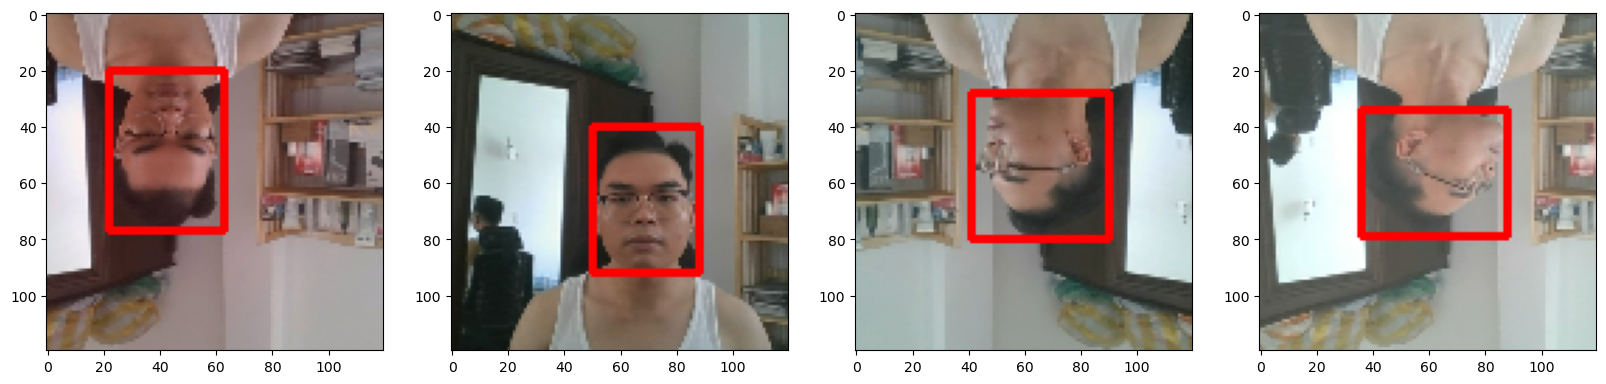

In [18]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()

# for idx in range(4) :
# print(res[1][1][1])

fig, ax = plt.subplots(ncols = 4, figsize=(20, 20))
for idx in range(4) :
  image_sample = np.array(res[0][idx])
  bbox_sample = res[1][1][idx]
  
  cv2.rectangle(
    image_sample,
    tuple(np.multiply(bbox_sample[:2], [120,120]).astype(int)),
    tuple(np.multiply(bbox_sample[2:], [120,120]).astype(int)),
    (255,0,0),
    2 
  )
  
  ax[idx].imshow(image_sample)

Build Deep Learning using the Functional API


In [65]:
# Import Layers and Base Network
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from keras.applications import VGG16

In [66]:
# Download VGG16
vgg = VGG16(include_top = False)
# vgg.summary()

In [67]:
# Build instance of Network
def build_model() :
  input_layer = Input(shape=(120,120,3))
  
  vgg = VGG16(include_top = False)(input_layer)
  
  # Classification Model
  f1 = GlobalMaxPooling2D()(vgg)
  class1 = Dense(2048, activation='relu')(f1)
  class2 = Dense(1, activation='sigmoid')(class1)
  
  #Bounding Box Model
  f2 = GlobalMaxPooling2D()(vgg)
  regress1 = Dense(2048, activation='relu')(f2)
  regress2 = Dense(4, activation='sigmoid')(regress1)
  
  return Model(inputs=input_layer, outputs=[class2, regress2])

In [68]:
# Test out Neural Network
face_tracker = build_model()
face_tracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [27]:
Xtrain, ytrain = train.as_numpy_iterator().next()
ytrain

(array([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.    , 0.    , 0.    , 0.    ],
        [0.1765, 0.3303, 0.494 , 0.7456],
        [0.3198, 0.3867, 0.7603, 0.745 ],
        [0.5894, 0.3535, 0.9824, 0.7754],
        [0.8296, 0.    , 1.    , 0.4304],
        [0.533 , 0.3062, 0.876 , 0.7627],
        [0.3826, 0.    , 0.773 , 0.2793],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16),
 array([b'', b'Long', b'Long', b'Long', b'Long', b'Long', b'Long', b''],
       dtype=object))

In [28]:
classes, coords = face_tracker.predict(Xtrain)


1/1 [==============================] - 0s 278ms/step


Define Losses and Optimizers


In [69]:
# Define Optimizer and Learning rate decay
batches_per_epoch = len(train)
learning_rate_decay = (1./0.75 - 1)/batches_per_epoch

In [70]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=learning_rate_decay)

In [71]:
# Create Localization Loss and Classification Loss
def localization_loss(y_true, yhat) :
  delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
  
  height_true = y_true[:,3] - y_true[:,1]
  width_true = y_true[:,2] - y_true[:,0]
  
  height_predicted = yhat[:,3] - yhat[:,1]
  width_predicted = yhat[:,2] - yhat[:,0]
  
  delta_size = tf.reduce_sum(tf.square(width_true - width_predicted) + tf.square(height_true - height_predicted))
  
  return delta_coord + delta_size

class_loss = tf.keras.losses.BinaryCrossentropy()
regress_loss = localization_loss

In [ ]:
# Test out Loss Metrics
class_loss(ytrain[0], classes), regress_loss(ytrain[1], coords)

Train Neural Network


In [73]:
# Create Custom Model Class
class FaceTracker(Model) :

    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        self.model = model

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.opt = opt
        self.classloss = classloss
        self.localizationloss = localizationloss

    def train_step(self, batch, **kwargs):
        Xtrain, ytrain = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(Xtrain, training=True)

            batch_classloss = self.classloss(ytrain[0], classes)
            batch_localizationloss = self.localizationloss(
                tf.cast(ytrain[1], tf.float32), coords
            )

            total_loss = batch_localizationloss + 0.5 * batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {
            "total_loss": total_loss,
            "class_loss": batch_classloss,
            "regress_loss": batch_localizationloss,
        }

    def test_step(self, batch, **kwargs) :
        Xtest, ytest = batch

        classes, coords = self.model(Xtest, training=False)

        batch_classloss = self.classloss(ytest[0], classes)
        batch_localizationloss = self.localizationloss(tf.cast(ytest[1], tf.float32), coords)

        total_loss = batch_localizationloss + 0.5 * batch_classloss

        return {
      "total_loss" : total_loss,
      "class_loss" : batch_classloss,
      "regress_loss" : batch_localizationloss
    }

    def call(self, X, **kwargs) :
        return self.model(X, **kwargs)

In [74]:
model = FaceTracker(face_tracker)

In [75]:
model.compile(opt, class_loss, regress_loss)

In [76]:
# Train
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs = 30, validation_data = val, callbacks = [tensorboard_callback])                                                          

Epoch 1/30
364/364 [==============================] - 247s 674ms/step - total_loss: 0.7406 - class_loss: 0.2799 - regress_loss: 0.6006 - val_total_loss: 0.0643 - val_class_loss: 0.0553 - val_regress_loss: 0.0366
Epoch 2/30
364/364 [==============================] - 252s 691ms/step - total_loss: 0.3298 - class_loss: 0.1378 - regress_loss: 0.2609 - val_total_loss: 0.0116 - val_class_loss: 0.0158 - val_regress_loss: 0.0037
Epoch 3/30
364/364 [==============================] - 245s 671ms/step - total_loss: 0.1990 - class_loss: 0.0833 - regress_loss: 0.1573 - val_total_loss: 0.0135 - val_class_loss: 0.0019 - val_regress_loss: 0.0126
Epoch 4/30
364/364 [==============================] - 244s 667ms/step - total_loss: 0.1430 - class_loss: 0.0552 - regress_loss: 0.1154 - val_total_loss: 0.1334 - val_class_loss: 0.1776 - val_regress_loss: 0.0446
Epoch 5/30
364/364 [==============================] - 242s 664ms/step - total_loss: 0.0934 - class_loss: 0.0375 - regress_loss: 0.0746 - val_total_loss:

Plot performance


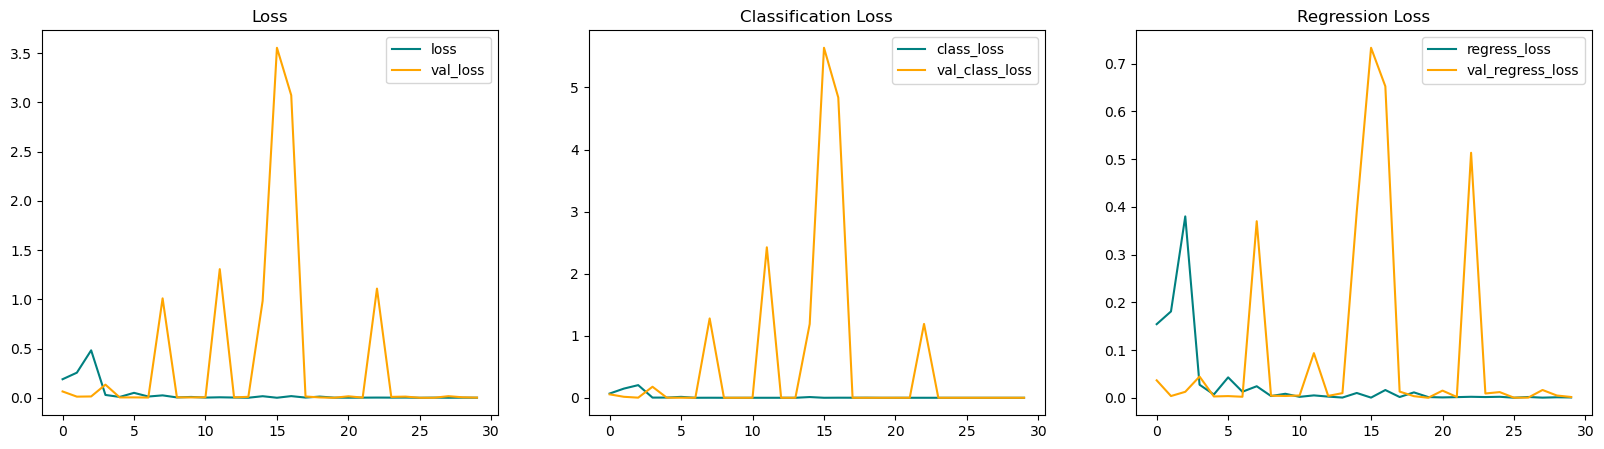

In [82]:
fig, ax = plt.subplots(ncols = 3, figsize = (20,5))

ax[0].plot(hist.history['total_loss'], color = 'teal', label = 'loss')
ax[0].plot(hist.history['val_total_loss'], color = 'orange', label = 'val_loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color = 'teal', label = 'class_loss')
ax[1].plot(hist.history['val_class_loss'], color = 'orange', label = 'val_class_loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color = 'teal', label = 'regress_loss')
ax[2].plot(hist.history['val_regress_loss'], color = 'orange', label = 'val_regress_loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

Make Prediction


1/1 [==============================] - 0s 217ms/step


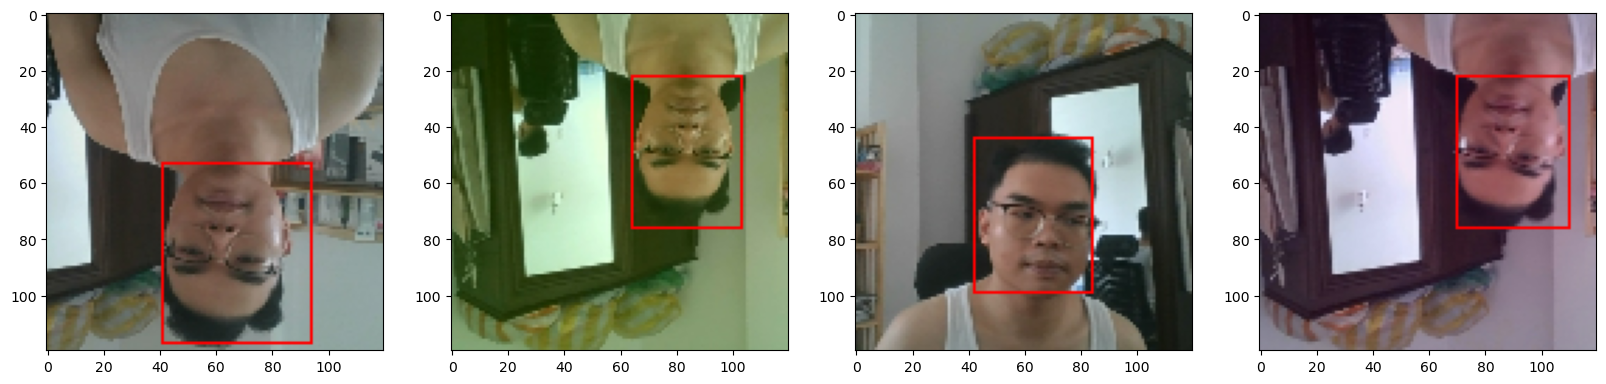

In [89]:
# Make prediction on Test set
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

yhat = face_tracker.predict(test_sample[0])

fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx in range(4) :
  sample_image = np.array(test_sample[0][idx])
  sample_coords = yhat[1][idx]
  
  if yhat[0][idx] > 0.5 :
    cv2.rectangle(
      sample_image,
      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
      (255,0,0),
      1 
    )
  ax[idx].imshow(sample_image)

Save model

In [80]:
face_tracker.save('Face_Detection_3.h5')
face_tracker.save('Face_Detection_3.tf')
face_tracker.save('Face_Detection_3.keras')

INFO:tensorflow:Assets written to: Face_Detection_2.tf/assets


INFO:tensorflow:Assets written to: Face_Detection_2.tf/assets


## Continue training on others

In [45]:
long_trained_model = load_model("Face_Detection_2.tf")
phuc_model = FaceTracker(long_trained_model)
phuc_model.compile(opt, class_loss, regress_loss)

logdir = "logs_phuc"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = phuc_model.fit(
    train, epochs=10, validation_data=val, callbacks=[tensorboard_callback]
)

Epoch 1/10
288/288 [==============================] - 214s 740ms/step - total_loss: 0.3850 - class_loss: 0.1453 - regress_loss: 0.3123 - val_total_loss: 0.0297 - val_class_loss: 1.9086e-04 - val_regress_loss: 0.0296
Epoch 2/10
288/288 [==============================] - 207s 716ms/step - total_loss: 0.1944 - class_loss: 0.0738 - regress_loss: 0.1575 - val_total_loss: 1.8356 - val_class_loss: 1.2591 - val_regress_loss: 1.2061
Epoch 3/10
288/288 [==============================] - 206s 711ms/step - total_loss: 0.1339 - class_loss: 0.0515 - regress_loss: 0.1082 - val_total_loss: 1.6607 - val_class_loss: 1.0767 - val_regress_loss: 1.1223
Epoch 4/10
288/288 [==============================] - 203s 704ms/step - total_loss: 0.0963 - class_loss: 0.0410 - regress_loss: 0.0758 - val_total_loss: 0.0060 - val_class_loss: 0.0070 - val_regress_loss: 0.0026
Epoch 5/10
288/288 [==============================] - 204s 707ms/step - total_loss: 0.0691 - class_loss: 0.0261 - regress_loss: 0.0560 - val_total_l

1/1 [==============================] - 0s 189ms/step


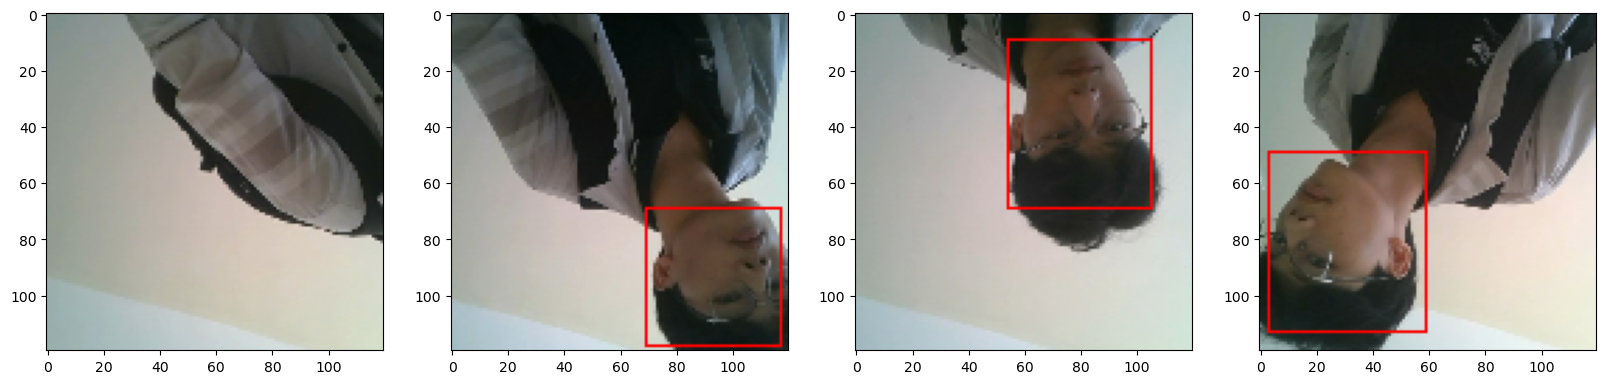

In [48]:
# Make prediction on Test set
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

yhat = phuc_model.predict(test_sample[0])

fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx in range(4) :
  sample_image = np.array(test_sample[0][idx])
  sample_coords = yhat[1][idx]
  
  if yhat[0][idx] > 0.5 :
    cv2.rectangle(
      sample_image,
      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
      (255,0,0),
      1 
    )
  ax[idx].imshow(sample_image)

In [50]:
# save new trained model
phuc_model.save("Face_Detection_2.h5")
phuc_model.save("Face_Detection_2.keras")

/opt/miniconda3/envs/face-recognition/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

Test load model and make prediction

1/1 [==============================] - 0s 298ms/step


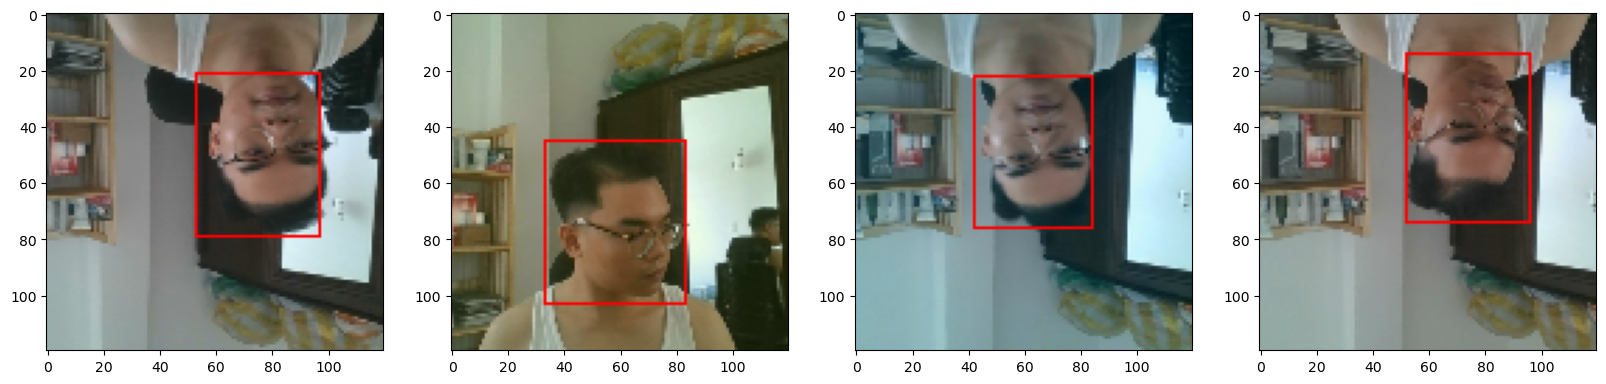

In [20]:
# Make prediction on Test set
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

facetracker = load_model("Face_Detection_1.keras")

yhat = facetracker.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = np.array(test_sample[0][idx])
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.5:
        cv2.rectangle(
            sample_image,
            tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
            tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
            (255, 0, 0),
            1,
        )
    ax[idx].imshow(sample_image)

Real time detection

In [ ]:
def performFaceDetection(vid) :
    facetracker = load_model("Face_Detection_1.keras")

    while True:
        result, frame = vid.read()
        if result is False:
            break
        frame = frame[50:1000, 50:1000, :]

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resized = tf.image.resize(rgb, (120, 120))

        yhat = facetracker.predict(np.expand_dims(resized / 255, 0))
        print(yhat)
        sample_coords = yhat[1][0]

        if yhat[0] > 0.5:
            # Control the main rectangle
            cv2.rectangle(
                frame,
                tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
                (255, 0, 0),
                2,
            )

        cv2.imshow("My Face Detection Project", frame) 
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    vid.release()
    cv2.destroyAllWindows()

def accessCamera(IP_Stream) :
  return cv2.VideoCapture(IP_Stream)

# url = 'http://192.168.1.105'
video_stream = accessCamera(0)
performFaceDetection(video_stream)